In [1]:
%matplotlib inline

import re, itertools, getpass, pymysql.cursors
from collections import Counter
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter

In [2]:
def ExecuteQuery(Connector, SQLQuery):

    Cursor = Connector.cursor()
    Cursor.execute(SQLQuery)
    Connector.commit()
    
    ReturnedRows = []

    while True:
        Row = Cursor.fetchone()
        if Row is None:
            break
        else:
            ReturnedRows.append(Row)

    return ReturnedRows

In [3]:
Connector = pymysql.connect(user=input("Username: "), password=getpass.getpass("Password: "), host='cedegemac8.epfl.ch', port=3306, charset='utf8mb4', use_unicode=True)

Username: hplearn
Password: ········


# Actions between submissions study

### User ids and Timestamps

In [4]:
output = ExecuteQuery(Connector, """
    SHOW COLUMNS
    FROM project_how_people_learn.Problem_Events_with_Info
""")

[out[0] for out in output]

['CourseID',
 'UserID',
 'TimeStamp',
 'EventType',
 'ProblemType',
 'ProblemID',
 'SubmissionNumber',
 'Grade',
 'MaximumSubmissions',
 'Title',
 'OpenTime',
 'SoftCloseTime',
 'HardCloseTime']

In [5]:
output = ExecuteQuery(Connector, """
    SELECT CourseID, UserID, TimeStamp, EventType, ProblemType, ProblemID, HardCloseTime
    FROM project_how_people_learn.Problem_Events_with_Info
    WHERE CourseID = 'progfun-2012-001'
""")

In [6]:
sub_events = pd.DataFrame(output, columns=['CourseID', 'UserID', 'TimeStamp', 'EventType', 'ProblemType', 'ProblemID', 'HardCloseTime'])
sub_events.head()

,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,HardCloseTime
0,progfun-2012-001,189749                                        ...,1348748287,Problem.Check,Video,42                              ,1.349784e+09
1,progfun-2012-001,3153                                          ...,1349290699,Problem.Check,Video,60                              ,1.350570e+09
2,progfun-2012-001,1336423                                       ...,1348237598,Problem.Check,Video,7                               ,2.147484e+09
3,progfun-2012-001,1780444                                       ...,1352990521,Problem.Check,Video,11                              ,2.147484e+09
4,progfun-2012-001,1355757                                       ...,1349559280,Problem.Check,Video,56                              ,1.350282e+09


In [7]:
sub_events['EventType'].unique()

array(['Problem.Check'], dtype=object)

In [8]:
sub_events['ProblemType'].unique()

array(['Video', 'Assignment', None], dtype=object)

In [9]:
sub_events_counts = sub_events.groupby(['UserID', 'ProblemID', 'HardCloseTime', 'ProblemType']).count()
sub_events_counts = sub_events_counts[sub_events_counts['CourseID'] >= 2]

sub_events_interest = sub_events_counts.reset_index()[['UserID', 'ProblemID', 'HardCloseTime', 'ProblemType']]
sub_events_interest = pd.merge(sub_events, sub_events_interest, on=['UserID', 'ProblemID', 'HardCloseTime', 'ProblemType'])

sub_events_stamps = sub_events_interest.groupby(['UserID', 'ProblemID', 'HardCloseTime', 'ProblemType'])['TimeStamp'].apply(list).reset_index()

In [10]:
def generate_time_pairs(stamps):
    pairs = []
    sorted_stamps = sorted(stamps)
    for i in range (len(sorted_stamps) - 1):
        pairs.append((sorted_stamps[i], sorted_stamps[i+1]))
    
    return pairs

In [11]:
sub_events_stamps['TimeStamp'] = sub_events_stamps['TimeStamp'].apply(generate_time_pairs)
sub_events_stamps['UserID'] = sub_events_stamps['UserID'].str.strip('\0')
sub_events_stamps.head()

,UserID,ProblemID,HardCloseTime,ProblemType,TimeStamp
0,1000012,14                              ,1.351584e+09,Assignment,"[(1350770327, 1350890561), (1350890561, 135095..."
1,1000012,17                              ,1.352408e+09,Assignment,"[(1351668355, 1351677202), (1351677202, 135180..."
2,1000012,20                              ,1.353618e+09,Assignment,"[(1352691728, 1352692363), (1352692363, 135269..."
3,1000012,6                               ,1.349766e+09,Assignment,"[(1349563379, 1349564422)]"
4,10003,11                              ,2.147484e+09,Video,"[(1348737876, 1348737898)]"


In [12]:
def flatten_list(l):
    return [x for sublist in l for x in sublist]

In [13]:
user_stamps = sub_events_stamps.groupby('UserID')['TimeStamp'].apply(flatten_list).reset_index()
user_stamps['UserID'] = user_stamps['UserID'].astype(str)
user_stamps['UserID'] = user_stamps['UserID'].apply(lambda x: x.split('\0',1)[0])
user_stamps['Count'] = user_stamps['TimeStamp'].apply(lambda x: len(x))
user_stamps.head()

,UserID,TimeStamp,Count
0,1000012,"[(1350770327, 1350890561), (1350890561, 135095...",12
1,10003,"[(1348737876, 1348737898), (1348677324, 134867...",8
2,100030,"[(1362649459, 1362649479), (1362649479, 136264...",5
3,1000352,"[(1377491483, 1377491496), (1348620649, 134862...",11
4,1000388,"[(1351241871, 1351241877), (1351241877, 135124...",31


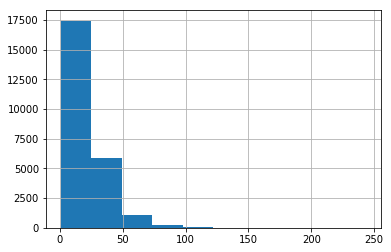

In [14]:
user_stamps['Count'].hist()

We select people of interest that have 25 or more timestamps intervals

In [15]:
user_stamps_interest = user_stamps[user_stamps['Count'] >= 25]
len(user_stamps_interest), len(user_stamps) # This still represents 6 millions rows in video events.... We should probably reduce more

(7798, 24784)

In [16]:
user_ids_interest = user_stamps_interest['UserID']

### User actions

For the course "progfun-2012-001", there are 10 Million entries in the video events dataset => we need to select potential interesting users to reduce the query sizes

In [17]:
# Select 1 target course
CourseID = 'progfun-2012-001' # Principles of Reactive Programming

Output = ExecuteQuery(Connector, """
    SELECT *
    FROM project_how_people_learn.Video_Events
    WHERE CourseID='%s'
""" % CourseID)

# Convert output to dataframe
video_events = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'TimeStamp', 'EventType', 'VideoID', 'CurrentTime', 'OldTime', 'NewTime', 'SeekType', 'OldSpeed', 'NewSpeed'])
video_events['UserID'] = video_events['UserID'].str.strip('\0')

In [18]:
# Total number of video events
len(video_events)

10450025

In [19]:
video_events['EventType'].unique()

array(['Video.Play', 'Video.Seek', 'Video.Pause', 'Video.SpeedChange',
       'Video.Load', 'Video.Download', 'Video.Error', 'Video.Stalled'],
      dtype=object)

In [20]:
# Number of video download
nb_download = sum(video_events['EventType'] == 'Video.Download')
print("Number of video downloads among all video events: %d" % nb_download)

Number of video downloads among all video events: 731648


This represents approximately 7% of all video events of the prog fun course

In [21]:
video_events_interest = video_events[video_events['UserID'].isin(user_ids_interest)]
len(video_events_interest)

5660024

In [22]:
def get_action_per_user(df):
    return sorted(list(zip(df['EventType'].values, df['TimeStamp'].values)), key= lambda x: x[1])

In [23]:
user_actions = video_events_interest.groupby('UserID').apply(get_action_per_user).reset_index()
user_actions = user_actions.rename(columns={0: 'Events'})
user_actions['UserID'] = user_stamps['UserID'].str.strip('\0')

In [24]:
user_events = pd.merge(user_actions, user_stamps, on='UserID')
user_events.head()

,UserID,Events,TimeStamp,Count
0,1000012,"[(Video.Play, 1348514323), (Video.Load, 134851...","[(1350770327, 1350890561), (1350890561, 135095...",12
1,10003,"[(Video.Load, 1347952867), (Video.Load, 134800...","[(1348737876, 1348737898), (1348677324, 134867...",8
2,100030,"[(Video.Play, 1348524565), (Video.Load, 134852...","[(1362649459, 1362649479), (1362649479, 136264...",5
3,1000352,"[(Video.Load, 1348025892), (Video.Load, 134802...","[(1377491483, 1377491496), (1348620649, 134862...",11
4,1000388,"[(Video.Load, 1347993450), (Video.Load, 134799...","[(1351241871, 1351241877), (1351241877, 135124...",31


In [25]:
user_actions_flattened = [[user_id, action, action[1]] for user_id, user_actions in user_actions.values for action in user_actions]
user_actions_flattened = pd.DataFrame(user_actions_flattened, columns=['UserID', 'Action', 'TimeStamp'])
user_actions_flattened.head()

,UserID,Action,TimeStamp
0,1000012,"(Video.Play, 1348514323)",1348514323
1,1000012,"(Video.Load, 1348514323)",1348514323
2,1000012,"(Video.Pause, 1348514361)",1348514361
3,1000012,"(Video.Play, 1348514436)",1348514436
4,1000012,"(Video.Pause, 1348514458)",1348514458


In [26]:
user_intervals_flattened = [[user_id, interval[0], interval[1]] for user_id, user_intervals, count in user_stamps_interest.values for interval in user_intervals]
user_intervals_flattened = pd.DataFrame(user_intervals_flattened, columns=['UserID', 'interval_start', 'interval_stop'])
user_intervals_flattened.head()

,UserID,interval_start,interval_stop
0,1000388,1351241871,1351241877
1,1000388,1351241877,1351241881
2,1000388,1351242841,1351242849
3,1000388,1351242849,1351242861
4,1000388,1351280968,1351280972


In [27]:
user_interval_actions = pd.merge(user_actions_flattened, user_intervals_flattened, on='UserID')

In [28]:
user_interval_actions = user_interval_actions[(user_interval_actions['interval_start'] <= user_interval_actions['TimeStamp']) & (user_interval_actions['TimeStamp'] <= user_interval_actions['interval_stop'])]
user_interval_actions = user_interval_actions.sort_values(['UserID', 'interval_start'])
user_interval_actions = user_interval_actions.groupby(['UserID', 'interval_start', 'interval_stop'])['Action'].apply(list).reset_index()
user_interval_actions = user_interval_actions.groupby('UserID')['Action'].apply(list).reset_index()

In [29]:
user_interval_actions.head()

,UserID,Action
0,100133,"[[(Video.Play, 1348767655), (Video.Load, 13487..."
1,1001468,"[[(Video.Play, 1350746330), (Video.Load, 13507..."
2,100161,"[[(Video.Play, 1348754224), (Video.Load, 13487..."
3,1001687,"[[(Video.Load, 1352072164), (Video.Play, 13520..."
4,100176,"[[(Video.Play, 1348591824), (Video.Load, 13485..."


In [30]:
user_interval_actions_id = user_interval_actions['UserID']

In [31]:
# Compare the initial number of interesting ids to the number of interesting ids now remaining
len(user_ids_interest), len(user_interval_actions_id)

(7798, 1669)

In [32]:
def create_window_list(events, window):
    length = len(events)
    if length < window:
        return []
    
    result = []
    for i in range(length - window + 1):
        result.append(events[i:(i+window)])
    return result

In [33]:
def apply_window(serie, w_size):
    return flatten_list([create_window_list(interval, w_size) for interval in serie])

In [34]:
def get_plot_values(actions_serie, w_size, threshold):
    windows = actions_serie.apply(lambda s: apply_window(s, w_size))
    n_windows = [list(zip(*x))[0] for x in flatten_list(windows.values)]
    n_windows_stat = Counter(n_windows)
    n_windows_stat = n_windows_stat.most_common()[::-1]
    n_windows_stat_keys, n_windows_stat_values = list(zip(*n_windows_stat))
    
    labels = np.array([', '.join(x) for x in n_windows_stat_keys])
    values = np.array(n_windows_stat_values)
    values = values / np.sum(values)
    non_zero_ids = values > threshold
    labels = labels[non_zero_ids]
    values = values[non_zero_ids]
    
    return dict(zip(labels, values))

In [35]:
def plot_actions_sequence_hist(actions_serie, w_size, threshold, figsize=(10, 30)):
    actions_dict = get_plot_values(actions_serie, w_size, threshold)
    labels, values = zip(*actions_dict.items())
    
    plt.figure(figsize=figsize)
    plt.barh(labels, values)
    plt.show()

In [36]:
def plot_hist_comparison(items_dict1, title1, items_dict2, title2, figsize=(10, 30)):
    keys = list(set(items_dict1.keys()).union(set(items_dict2.keys())))
    values1 = []
    values2 = []
    for key in keys:
        values1.append((items_dict1.get(key, 0)))
        values2.append((items_dict2.get(key, 0)))
    
    df = pd.DataFrame({title1:values1, title2:values2}, index=keys)
    df = df.sort_values('passing')
    df.plot.barh(figsize=figsize)

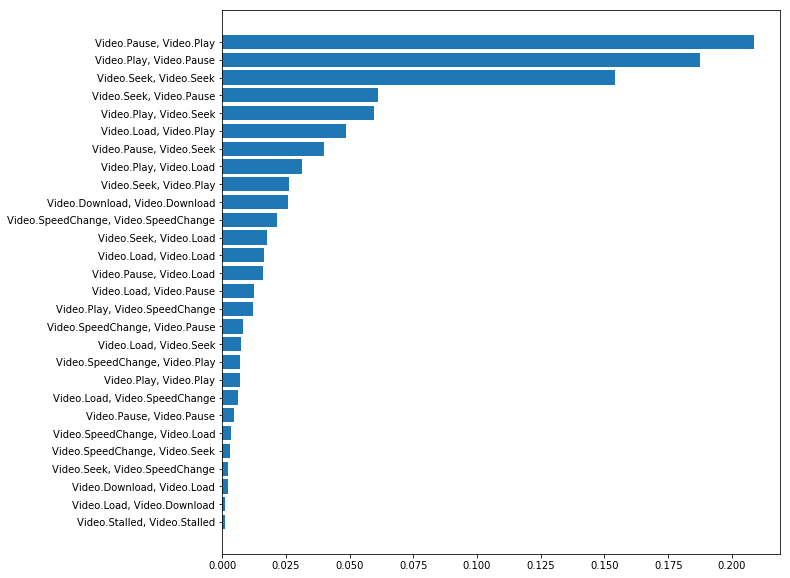

In [37]:
plot_actions_sequence_hist(user_interval_actions['Action'], 2, 0.001, figsize=(10, 10))

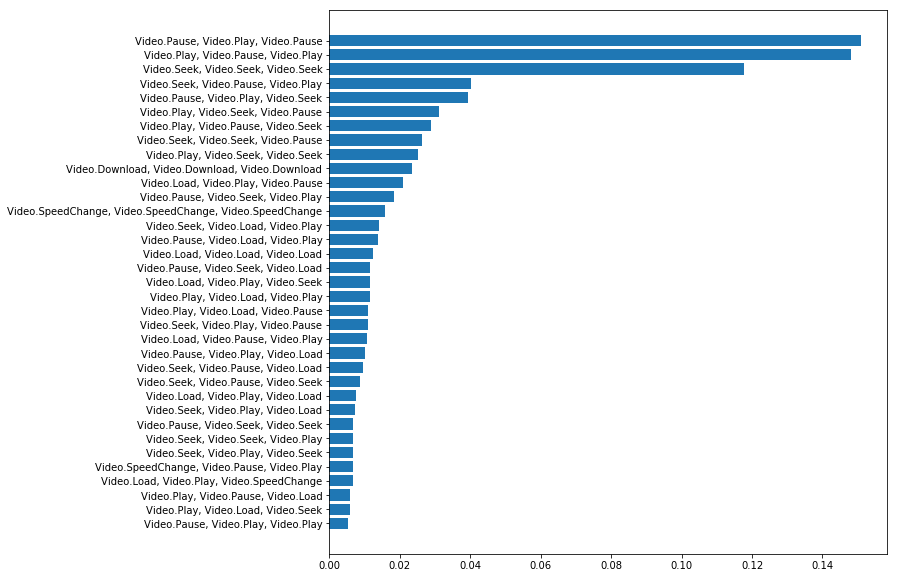

In [38]:
plot_actions_sequence_hist(user_interval_actions['Action'], 3, 0.005, figsize=(10, 10))

### Forum events

In [39]:
all_users_stamps_id = user_stamps['UserID']

In [40]:
CourseID = 'progfun-2012-001' # Principles of Reactive Programming

Output = ExecuteQuery(Connector, """
    SELECT *
    FROM project_how_people_learn.forum_events
    WHERE CourseID='%s'
""" % CourseID)

# Convert output to dataframe
forum_events = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'TimeStamp', 'EventType', 'PostType', 'PostID'])
forum_events['UserID'] = forum_events['UserID'].str.strip('\0')

In [41]:
forum_events_user_passed = forum_events[forum_events['UserID'].isin(all_users_stamps_id)]
forum_events.size

1512372

### Check intersection with passing students

In [42]:
CourseID = 'progfun-2012-001' 

# Fetch grade history of students who took selected course
Output = ExecuteQuery(Connector, """
    SELECT * 
    FROM project_how_people_learn.user_grades
    WHERE CourseID='%s' AND AchievementLevel = 'Passed'
""" % CourseID)

# Convert output to dataframe
grades_df = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'Grade', 'AchievementLevel', 'Distinction'])
grades_df['UserID'] = grades_df['UserID'].str.strip('\0')

In [43]:
# Total number of student passing the course
len(grades_df)

9593

In [44]:
# Current number of student remaining in the studied frame
nb_students_remaining = len(user_interval_actions['UserID'])
nb_students_remaining

1669

In [45]:
user_interval_actions_passing_ids = grades_df['UserID'][grades_df['UserID'].isin(user_interval_actions_id)]

In [46]:
# Current number of student remaining in the studied frame and passing the course
nb_students_remaining_passing = len(user_interval_actions_passing_ids)
nb_students_remaining_passing, nb_students_remaining_passing / nb_students_remaining

(1285, 0.7699221090473337)

In [47]:
# Current number of student remaining in the studied frame and failing the course
nb_students_remaining_failing = sum(~(user_interval_actions['UserID'].isin(user_interval_actions_passing_ids)))
nb_students_remaining_failing, nb_students_remaining_failing / nb_students_remaining

(384, 0.23007789095266626)

In [48]:
user_interval_actions.head()

,UserID,Action
0,100133,"[[(Video.Play, 1348767655), (Video.Load, 13487..."
1,1001468,"[[(Video.Play, 1350746330), (Video.Load, 13507..."
2,100161,"[[(Video.Play, 1348754224), (Video.Load, 13487..."
3,1001687,"[[(Video.Load, 1352072164), (Video.Play, 13520..."
4,100176,"[[(Video.Play, 1348591824), (Video.Load, 13485..."


The current studied frame was the result of the following selection process:
* For all users, find out their submission intervals for each homework, e.g. if a student submit 3 times at time t1, t2 and t3, the intervals of this student for homework 1 will be ((t1, t2), (t2, t3))
* Filter all students having less than 25 such intervals for all homeworks taken together and only keep the ones having 25 or more such intervals
* Filter all students that don't have any video events during any of these intervals and only keep the ones that have at least on video event in any of these intervals

What we notice is that after this selection process, only 1669 entries remain. Among those 1668 entries, 1285 entries (77%) correspond to students passing the course and the other 384 entries (23%) correspond to student failing the course. It seems therefore that students having done a lot of submissions overall and having watched/rewatched videos in between tend to finish and pass the course. This statement is only valid for students having done more than 26 submissions over all homework.

OR

The fact that fewer failing students are found among those entries simply shows that there are fewer failing students doing submissions. This would make sense because other studies have shown that the majority of failing students tends to be students dropping the course after 2 weeks.

=> SHOULD STUDY entries to see the distribution of submission over the homeworks, how much the first homeworks contribute to the overall amount of submissions. Find result below.

In [49]:
user_interval_actions_passing = user_interval_actions[user_interval_actions['UserID'].isin(user_interval_actions_passing_ids)]
user_interval_actions_passing.head()

,UserID,Action
0,100133,"[[(Video.Play, 1348767655), (Video.Load, 13487..."
1,1001468,"[[(Video.Play, 1350746330), (Video.Load, 13507..."
2,100161,"[[(Video.Play, 1348754224), (Video.Load, 13487..."
3,1001687,"[[(Video.Load, 1352072164), (Video.Play, 13520..."
4,100176,"[[(Video.Play, 1348591824), (Video.Load, 13485..."


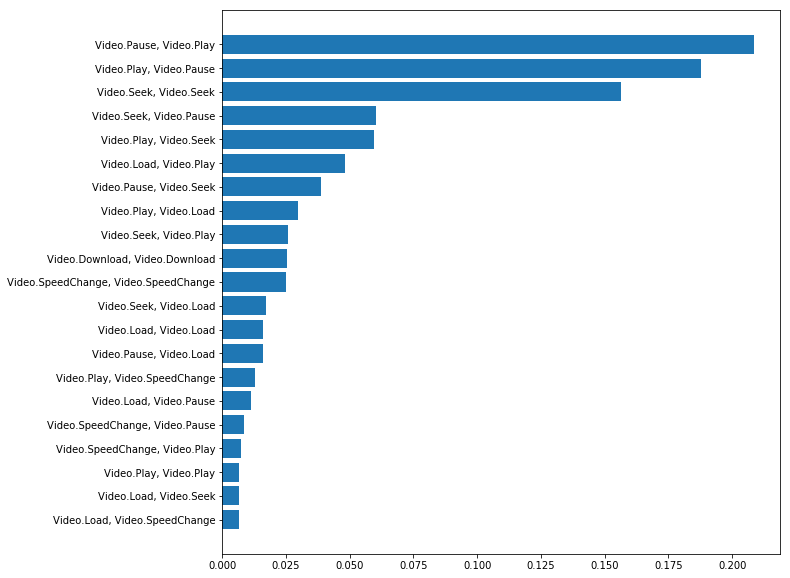

In [50]:
plot_actions_sequence_hist(user_interval_actions_passing['Action'], 2, 0.005, figsize=(10, 10))

### Failing students

In [51]:
user_interval_actions_failing = user_interval_actions[~(user_interval_actions['UserID'].isin(user_interval_actions_passing_ids))]
user_interval_actions_failing_ids = user_interval_actions_failing['UserID']
user_interval_actions_failing.head()

,UserID,Action
5,1001769,"[[(Video.Play, 1348364989), (Video.Load, 13483..."
9,1003119,"[[(Video.Load, 1349935969), (Video.Play, 13499..."
10,1003282,"[[(Video.Pause, 1349793296), (Video.Play, 1349..."
12,1004402,"[[(Video.Load, 1348617911), (Video.Load, 13486..."
16,100611,"[[(Video.Download, 1348774524), (Video.Downloa..."


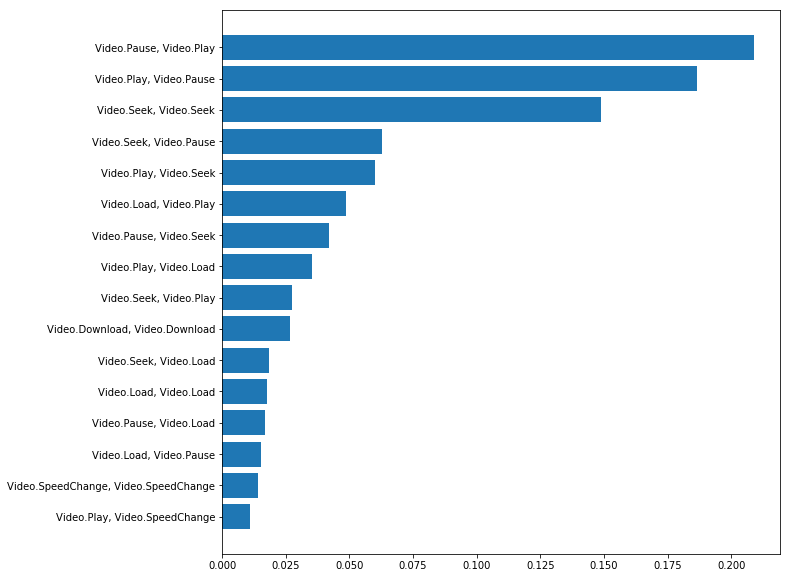

In [52]:
plot_actions_sequence_hist(user_interval_actions_failing['Action'], 2, 0.01, figsize=(10, 10))

We notice that the histogram of actions of passing students looks the same as the histogram of actions of failing students.  This indicates that for failing students that do quite a lot of submission the reason why they fail probably do not reside in the actions that they are doing in between two submissions.

### Comparison plot

In [53]:
passing_dict_2 = get_plot_values(user_interval_actions_passing['Action'], 2, 0.005)
failing_dict_2 = get_plot_values(user_interval_actions_failing['Action'], 2, 0.005)

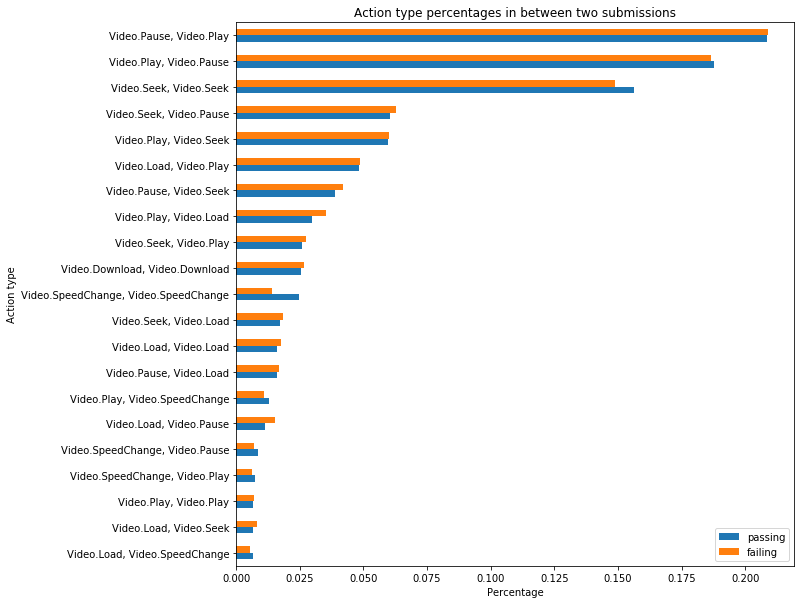

In [54]:
plot_hist_comparison(passing_dict_2, 'passing', failing_dict_2, 'failing', figsize=(10, 10))
plt.title("Action type percentages in between two submissions")
plt.xlabel("Percentage")
plt.ylabel("Action type")
plt.savefig("passing_failing_seq_2.png", dpi=250, bbox_inches="tight")

In [55]:
passing_dict_3 = get_plot_values(user_interval_actions_passing['Action'], 3, 0.005)
failing_dict_3 = get_plot_values(user_interval_actions_failing['Action'], 3, 0.005)

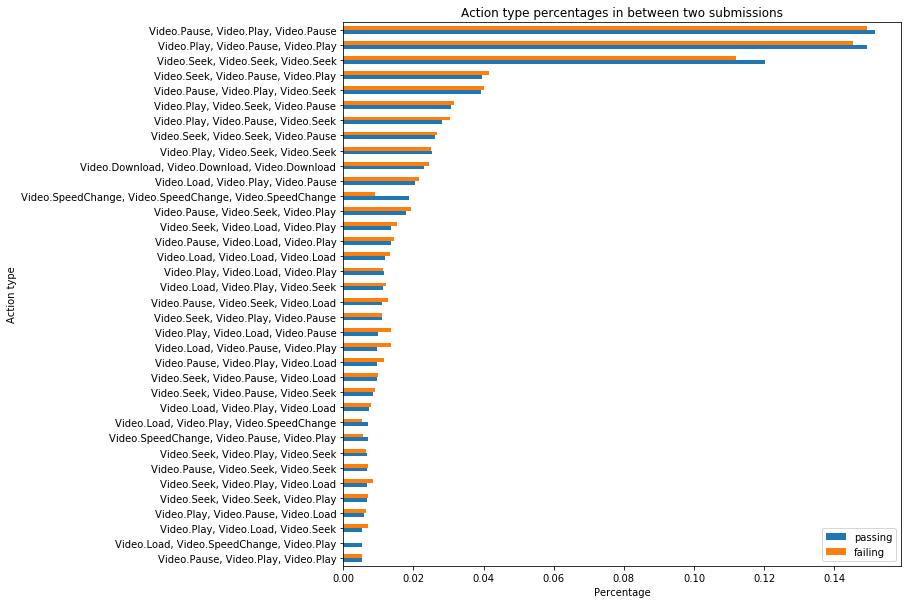

In [56]:
plot_hist_comparison(passing_dict_3, 'passing', failing_dict_3, 'failing', figsize=(10, 10))
plt.title("Action type percentages in between two submissions")
plt.xlabel("Percentage")
plt.ylabel("Action type")
plt.savefig("passing_failing_seq_3.png", dpi=250, bbox_inches="tight")

In [57]:
# How many problems did passing students submit [ALL PROBLEMS TYPE]
sub_events_passing = sub_events_stamps[sub_events_stamps['UserID'].isin(user_interval_actions_passing_ids)][['UserID', 'ProblemID']]
sub_probid_passing = sub_events_passing.groupby('UserID').count()['ProblemID']
sub_probid_passing.median()

13.0

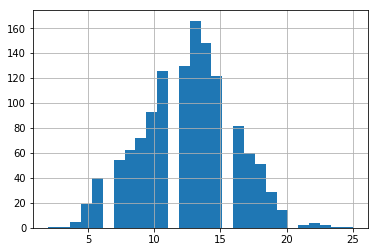

In [58]:
sub_probid_passing.hist(bins=28)

In [59]:
# How many problems did failing students submit [ALL PROBLEMS TYPE]
sub_events_failing = sub_events_stamps[sub_events_stamps['UserID'].isin(user_interval_actions_failing_ids)][['UserID', 'ProblemID']]
sub_probid_failing = sub_events_failing.groupby('UserID').count()['ProblemID']
sub_probid_failing.median()

8.0

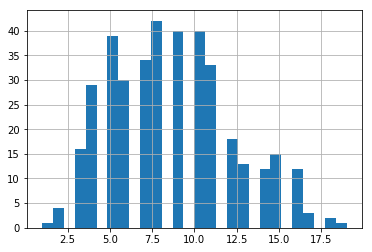

In [60]:
sub_probid_failing.hist(bins=28)

In [61]:
# Number of different problems [ALL PROBLEMS TYPE]
len(sub_events_stamps['ProblemID'].str.strip('\0').unique())

28

In [62]:
# How many assignments did passing students submit ?
sub_events_passing_ass = sub_events_stamps[(sub_events_stamps['UserID'].isin(user_interval_actions_passing_ids)) & (sub_events_stamps['ProblemType'] == 'Assignment')][['UserID', 'ProblemID']]
sub_probid_passing_ass = sub_events_passing_ass.groupby('UserID').count()['ProblemID']
sub_probid_passing_ass.median()

5.0

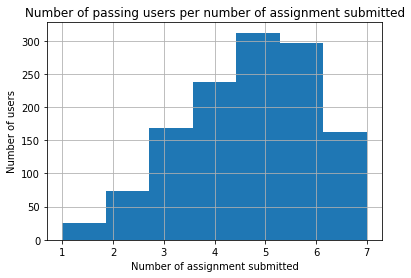

In [63]:
sub_probid_passing_ass.hist(bins=7)
plt.title('Number of passing users per number of assignment submitted')
plt.xlabel('Number of assignment submitted')
plt.ylabel('Number of users')
plt.savefig('passing_users_assignment_histogram', dpi=250, bbox_inches='tight')

In [64]:
# How many assignments did failing students submit
sub_events_failing_ass = sub_events_stamps[(sub_events_stamps['UserID'].isin(user_interval_actions_failing_ids)) & (sub_events_stamps['ProblemType'] == 'Assignment')][['UserID', 'ProblemID']]
sub_probid_failing_ass = sub_events_failing_ass.groupby('UserID').count()['ProblemID']
sub_probid_failing_ass.median()

3.0

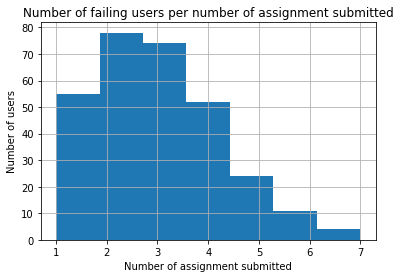

In [91]:
sub_probid_failing_ass.hist(bins=7)
plt.title('Number of failing users per number of assignment submitted')
plt.xlabel('Number of assignment submitted')
plt.ylabel('Number of users')
plt.savefig('failing_users_assignment_histogram', dpi=250, bbox_inches='tight')

In [66]:
# Number of different assignments
len(sub_events_stamps[sub_events_stamps['ProblemType'] == 'Assignment']['ProblemID'].str.strip('\0').unique())

7

# More general analysis of action of users

### Passing students

In [67]:
passing_user_video_events = video_events[video_events['UserID'].isin(grades_df['UserID'])]
len(passing_user_video_events)

5751659

In [68]:
# Check if we can use old time and current time to determine if this a seek is a rewind or a skip


In [69]:
# Check if new time is anything else than None
video_events['NewTime'].unique()

array([None], dtype=object)

The attributes "NewTime" is useless

In [70]:
user_actions_passed = pd.DataFrame(passing_user_video_events.groupby('UserID').apply(get_action_per_user), columns=['actions'])
user_actions_passed.head()

,actions
UserID,
1000012,"[(Video.Load, 1348045357), (Video.Load, 134804..."
1000388,"[(Video.Play, 1348514323), (Video.Load, 134851..."
1000592,"[(Video.Load, 1348048609), (Video.Load, 134804..."
1001078,"[(Video.Load, 1347949802), (Video.Download, 13..."
100133,"[(Video.Load, 1348025892), (Video.Load, 134802..."


In [71]:
CourseID = 'progfun-2012-001' # Principles of Reactive Programming

Output = ExecuteQuery(Connector, """
    SELECT CourseID, UserID, TimeStamp, ProblemType
    FROM project_how_people_learn.Problem_Events_with_Info
    WHERE CourseID='%s'
""" % CourseID)

# Convert output to dataframe
problem_events = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'TimeStamp', 'ProblemType'])
problem_events['UserID'] = problem_events['UserID'].str.strip('\0')
len(problem_events), sum(problem_events['UserID'].isin(grades_df['UserID']))

(757606, 457659)

In [72]:
passing_user_problem_events = problem_events[problem_events['UserID'].isin(grades_df['UserID'])]
passing_user_problem_events.head()

,CourseID,UserID,TimeStamp,ProblemType
0,progfun-2012-001,189749,1348748287,Video
1,progfun-2012-001,3153,1349290699,Video
2,progfun-2012-001,1336423,1348237598,Video
4,progfun-2012-001,1355757,1349559280,Video
5,progfun-2012-001,1342401,1348620860,Video


In [73]:
def get_problem_per_user(df):
    return sorted(list(zip(df['ProblemType'].values, df['TimeStamp'].values)), key= lambda x: x[1])

In [74]:
user_events_passed = pd.DataFrame(passing_user_problem_events.groupby('UserID').apply(get_problem_per_user), columns=['problem'])
user_events_passed.head()

,problem
UserID,
1000012,"[(Assignment, 1348374305), (Assignment, 134956..."
1000388,"[(Video, 1348563732), (Video, 1348563736), (Vi..."
1000592,"[(Assignment, 1347873600), (Video, 1348125447)..."
1001078,"[(Assignment, 1347631039), (Assignment, 134769..."
100133,"[(Video, 1348530767), (Video, 1348530770), (Vi..."


In [75]:
user_action_problem = pd.merge(user_actions_passed, user_events_passed, how='outer', left_index=True, right_index=True)
user_action_problem['all'] = user_action_problem['actions'] ++ user_action_problem['problem']
user_action_problem = user_action_problem.dropna()
user_action_problem['all'] = user_action_problem['all'].apply(lambda x: [y for y in x if None not in y])
user_action_problem['all'] = user_action_problem['all'].apply(lambda x: sorted(x, key=lambda y: y[1]))
user_action_problem = user_action_problem.drop(['actions', 'problem'], axis=1)
user_action_problem.head()

,all
UserID,
1000012,"[(Video.Load, 1348045357), (Video.Load, 134804..."
1000388,"[(Video.Play, 1348514323), (Video.Load, 134851..."
1000592,"[(Assignment, 1347873600), (Video.Load, 134804..."
1001078,"[(Assignment, 1347631039), (Assignment, 134769..."
100133,"[(Video.Load, 1348025892), (Video.Load, 134802..."


In [76]:
len(user_action_problem)

9569

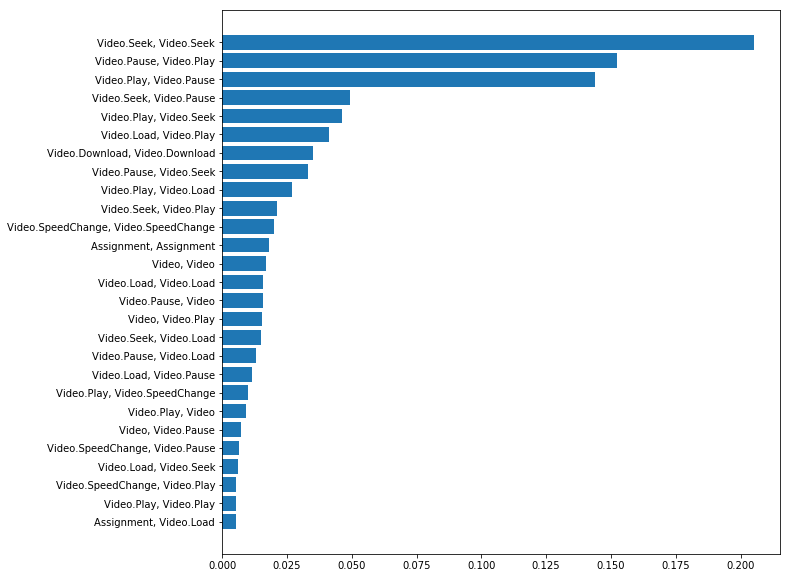

In [77]:
plot_actions_sequence_hist(user_action_problem, 2, 0.005, figsize=(10, 10))

In [78]:
general_passing_dict_2 = get_plot_values(user_action_problem, 2, 0.005)

In [79]:
general_passing_dict_2['Assignment, Assignment'] * 100

1.7894035923569183

1.79% of all action pairs are consecutive submissions without any actions in between for passing students

### Failing students

In [80]:
failing_user_video_events = video_events[~(video_events['UserID'].isin(grades_df['UserID']))]
len(failing_user_video_events)

4698366

In [81]:
user_actions_failed = pd.DataFrame(failing_user_video_events.groupby('UserID').apply(get_action_per_user), columns=['actions'])
user_actions_failed.head()

,actions
UserID,
100009,"[(Video.Load, 1363710806)]"
1000235,"[(Video.Load, 1348001583), (Video.Load, 134803..."
1000259,"[(Video.Load, 1353524674), (Video.Play, 135352..."
10003,"[(Video.Load, 1347968993), (Video.Load, 134796..."
100030,"[(Video.Load, 1348099017), (Video.Play, 134809..."


In [82]:
failing_user_problem_events = problem_events[~(problem_events['UserID'].isin(grades_df['UserID']))]
failing_user_problem_events.head()

,CourseID,UserID,TimeStamp,ProblemType
3,progfun-2012-001,1780444,1352990521,Video
9,progfun-2012-001,79240,1350920280,Assignment
13,progfun-2012-001,42378,1348229562,Video
14,progfun-2012-001,157329,1352929463,Video
16,progfun-2012-001,1425936,1349631287,Video


In [83]:
user_events_failed = pd.DataFrame(failing_user_problem_events.groupby('UserID').apply(get_problem_per_user), columns=['problem'])
user_events_failed.head()

,problem
UserID,
1000235,"[(Video, 1352962226), (Video, 1353394944), (As..."
10003,"[(Video, 1348677324), (Video, 1348677326), (Vi..."
100030,"[(Video, 1362649459), (Video, 1362649479), (Vi..."
1000352,"[(Video, 1348620649), (Video, 1348620680), (Vi..."
1000374,"[(Assignment, 1348768614), (Assignment, 134971..."


In [84]:
user_action_problem_failed = pd.merge(user_actions_failed, user_events_failed, how='outer', left_index=True, right_index=True)
user_action_problem_failed['all'] = user_action_problem_failed['actions'] ++ user_action_problem_failed['problem']
user_action_problem_failed = user_action_problem_failed.dropna()
user_action_problem_failed['all'] = user_action_problem_failed['all'].apply(lambda x: [y for y in x if None not in y])
user_action_problem_failed['all'] = user_action_problem_failed['all'].apply(lambda x: sorted(x, key=lambda y: y[1]))
user_action_problem_failed = user_action_problem_failed.drop(['actions', 'problem'], axis=1)
user_action_problem_failed.head()

,all
UserID,
1000235,"[(Video.Load, 1348001583), (Video.Load, 134803..."
10003,"[(Video.Load, 1347968993), (Video.Load, 134796..."
100030,"[(Video.Load, 1348099017), (Video.Play, 134809..."
1000352,"[(Video.Load, 1348601433), (Video.Play, 134860..."
1000374,"[(Video.Load, 1347986620), (Video.Load, 134798..."


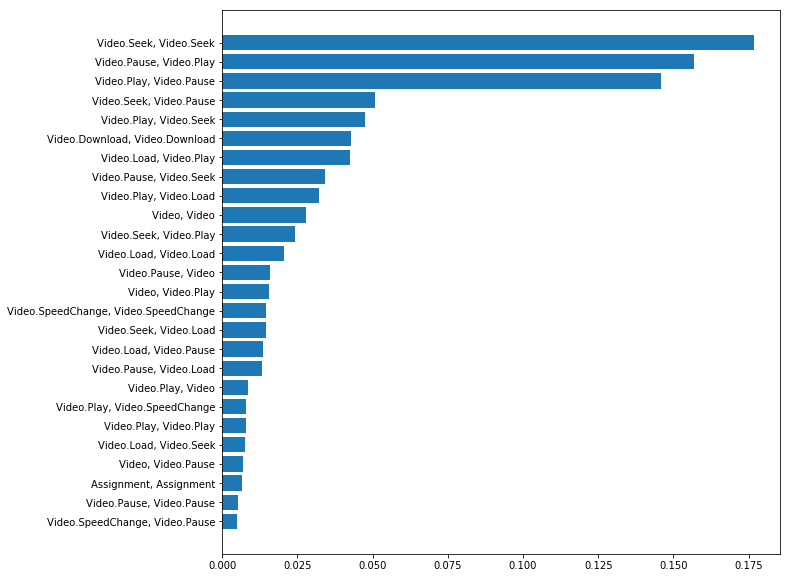

In [85]:
plot_actions_sequence_hist(user_action_problem_failed, 2, 0.005, figsize=(10, 10))

In [86]:
general_failing_dict_2 = get_plot_values(user_action_problem_failed, 2, 0.005)

In [87]:
general_failing_dict_2['Assignment, Assignment'] * 100

0.6703548076107468

0.67% of all action pairs are consecutive submissions without any actions in between for failing students. This number is lower than for passing students probably because a lot of failing students do not participate to the majority of submissions and/or some of them are only interested in watching the videos, not doing the exercises.

 We also notice that the overall number of video events for passing students is 5'751'659 vs 4'698'366 for failing students. However, we also know that the number of passing students is 9'593 vs 43'678 failing students. More than half the video events come from a fifth of the number of registered students. This means that the majority of failing students tends to stop watching videos because they lose interest in the course and stop it.

### General passing/failing plot comparison

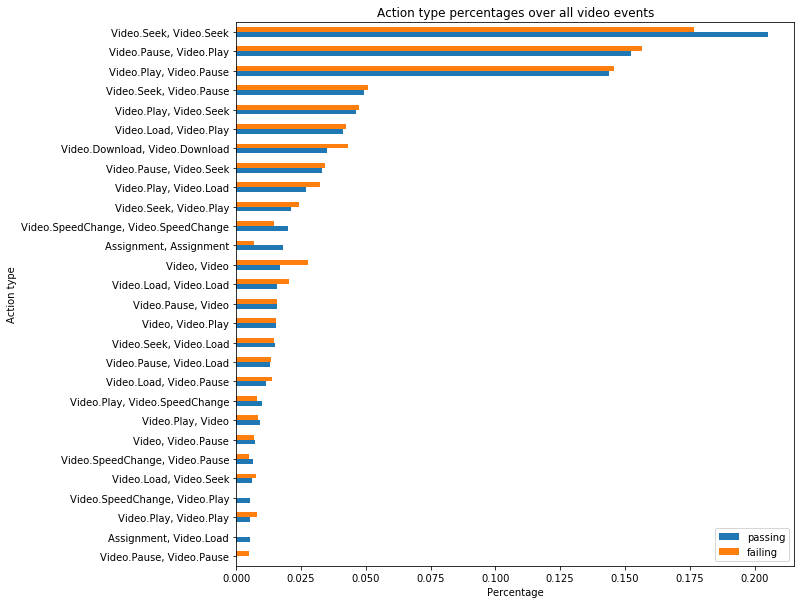

In [88]:
plot_hist_comparison(general_passing_dict_2, "passing", general_failing_dict_2, "failing", figsize=(10, 10))
plt.title("Action type percentages over all video events")
plt.xlabel("Percentage")
plt.ylabel("Action type")
plt.savefig("general_passing_failing_seq_2.png", dpi=250, bbox_inches="tight")

In [89]:
general_passing_dict_3 = get_plot_values(user_action_problem, 3, 0.005)
general_failing_dict_3 = get_plot_values(user_action_problem_failed, 3, 0.005)

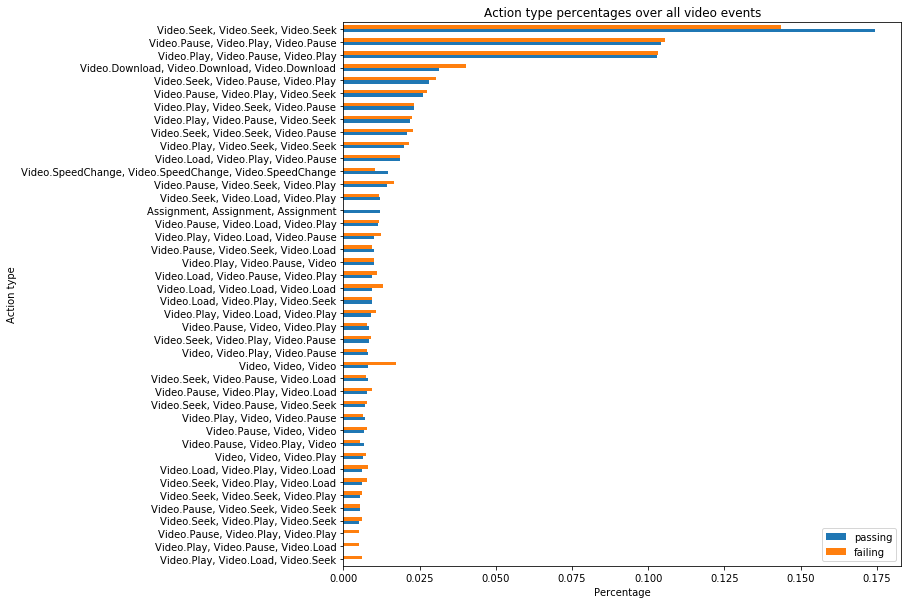

In [90]:
plot_hist_comparison(general_passing_dict_3, "passing", general_failing_dict_3, "failing", figsize=(10, 10))
plt.title("Action type percentages over all video events")
plt.xlabel("Percentage")
plt.ylabel("Action type")
plt.savefig("general_passing_failing_seq_3.png", dpi=250, bbox_inches="tight")